# 02. Data Preprocessing

This notebook focuses on preprocessing the EXIST2025 dataset for model training. Based on our EDA findings:
- Keep `word_count` but remove `tweet_length` (correlation 0.929)
- Preserve URLs and hashtags as features (Chi-square significant: χ²=93.39 and χ²=67.33)
- Use `avg_word_length` (strongest correlation: r=-0.147)
- Consider `task1_agreement` for sample weighting (r=-0.126)

## Objectives
1. Text cleaning and normalization
2. Feature extraction from special patterns (URLs, mentions, hashtags, emojis)
3. Tokenization for Spanish text
4. Feature engineering based on EDA insights
5. Prepare train/validation splits
6. Export preprocessed data

In [36]:
import pandas as pd
import numpy as np
import re
import json
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# For text processing
import unicodedata
from typing import List, Dict, Tuple

## 1. Load Data

In [37]:
# Load training data
data_path = Path('..') / 'lab1_materials' / 'dataset_task1_exist2025'

with open(data_path / 'training.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

with open(data_path / 'test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 6064
Test samples: 934


In [38]:
# Convert to DataFrame (training.json is a dict, so extract values)
train_df = pd.DataFrame(list(train_data.values()))
test_df = pd.DataFrame(list(test_data.values()))

# Calculate majority vote for labels (they are already in the data)
def majority_vote(labels_list):
    """Get majority label from list of annotator labels."""
    if not labels_list:
        return None
    # Count occurrences and return most common
    return Counter(labels_list).most_common(1)[0][0]

# Get consensus labels from individual annotations
train_df['task1'] = train_df['labels_task1'].apply(majority_vote)
train_df['task2'] = train_df['labels_task2'].apply(majority_vote)
# For task3, labels are lists of lists, so we need to flatten first
train_df['task3'] = train_df['labels_task3'].apply(lambda x: majority_vote([str(item) for item in x]))

print("\nTraining data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nTraining data columns:", train_df.columns.tolist())
print("\nTask1 label distribution:")
print(train_df['task1'].value_counts())


Training data shape: (6064, 17)
Test data shape: (934, 11)

Training data columns: ['id_EXIST', 'lang', 'tweet', 'number_annotators', 'annotators', 'gender_annotators', 'age_annotators', 'ethnicities_annotators', 'study_levels_annotators', 'countries_annotators', 'labels_task1', 'labels_task2', 'labels_task3', 'split', 'task1', 'task2', 'task3']

Task1 label distribution:
task1
NO     3367
YES    2697
Name: count, dtype: int64


## 2. Text Preprocessing Functions

We'll create modular preprocessing functions for different cleaning levels.

In [39]:
# Regular expressions for pattern detection
URL_PATTERN = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
MENTION_PATTERN = re.compile(r'@\w+')
HASHTAG_PATTERN = re.compile(r'#\w+')
EMOJI_PATTERN = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE
)

def extract_special_patterns(text: str) -> Dict[str, any]:
    """Extract special patterns from text."""
    return {
        'urls': URL_PATTERN.findall(text),
        'mentions': MENTION_PATTERN.findall(text),
        'hashtags': HASHTAG_PATTERN.findall(text),
        'emojis': EMOJI_PATTERN.findall(text)
    }

def count_special_patterns(text: str) -> Dict[str, int]:
    """Count special patterns in text."""
    patterns = extract_special_patterns(text)
    return {
        'n_urls': len(patterns['urls']),
        'n_mentions': len(patterns['mentions']),
        'n_hashtags': len(patterns['hashtags']),
        'n_emojis': len(patterns['emojis'])
    }

# Test the functions
sample_text = train_df['tweet'].iloc[0]
print("Sample tweet:", sample_text)
print("\nPattern counts:", count_special_patterns(sample_text))
print("\nExtracted patterns:", extract_special_patterns(sample_text))

Sample tweet: @TheChiflis Ignora al otro, es un capullo.El problema con este youtuber denuncia el acoso... cuando no afecta a la gente de izquierdas. Por ejemplo, en su video sobre el gamergate presenta como "normal" el acoso que reciben Fisher, Anita o Zöey cuando hubo hasta amenazas de bomba.

Pattern counts: {'n_urls': 0, 'n_mentions': 1, 'n_hashtags': 0, 'n_emojis': 0}

Extracted patterns: {'urls': [], 'mentions': ['@TheChiflis'], 'hashtags': [], 'emojis': []}


In [40]:
def clean_text_light(text: str) -> str:
    """Light cleaning: preserve structure, just normalize whitespace."""
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def clean_text_medium(text: str, preserve_patterns: bool = True) -> str:
    """Medium cleaning: replace special patterns with tokens."""
    if preserve_patterns:
        # Replace URLs, mentions, hashtags with special tokens
        text = URL_PATTERN.sub(' URL ', text)
        text = MENTION_PATTERN.sub(' MENTION ', text)
        # Keep hashtag text but mark it
        text = re.sub(r'#(\w+)', r'HASHTAG_\1', text)
    else:
        # Remove special patterns
        text = URL_PATTERN.sub(' ', text)
        text = MENTION_PATTERN.sub(' ', text)
        text = HASHTAG_PATTERN.sub(' ', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def clean_text_aggressive(text: str) -> str:
    """Aggressive cleaning: remove all special characters."""
    # Remove URLs, mentions, hashtags
    text = URL_PATTERN.sub(' ', text)
    text = MENTION_PATTERN.sub(' ', text)
    text = HASHTAG_PATTERN.sub(' ', text)
    text = EMOJI_PATTERN.sub(' ', text)
    
    # Remove punctuation except important ones for negation
    text = re.sub(r'[^a-zA-ZáéíóúñÁÉÍÓÚÑüÜ\s!?¡¿]', ' ', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text.strip()

# Test cleaning levels
sample = train_df['tweet'].iloc[10]
print("Original:", sample)
print("\nLight:", clean_text_light(sample))
print("\nMedium (preserve):", clean_text_medium(sample, preserve_patterns=True))
print("\nMedium (remove):", clean_text_medium(sample, preserve_patterns=False))
print("\nAggressive:", clean_text_aggressive(sample))

Original: Me perdí la charada sicotica del #Gamergate (bueno, no tanto, gracias a @FeelAndCoffee 😊), pero no me perderé ésta. https://t.co/Lrro0HNR4z

Light: Me perdí la charada sicotica del #Gamergate (bueno, no tanto, gracias a @FeelAndCoffee 😊), pero no me perderé ésta. https://t.co/Lrro0HNR4z

Medium (preserve): Me perdí la charada sicotica del HASHTAG_Gamergate (bueno, no tanto, gracias a MENTION 😊), pero no me perderé ésta. URL

Medium (remove): Me perdí la charada sicotica del (bueno, no tanto, gracias a 😊), pero no me perderé ésta.

Aggressive: me perdí la charada sicotica del bueno no tanto gracias a pero no me perderé ésta


## 3. Feature Engineering Based on EDA

Based on our correlation analysis:
- **Keep**: `avg_word_length` (r=-0.147, most informative)
- **Keep**: `word_count` (unique information)
- **Remove**: `tweet_length` (redundant, r=0.929 with word_count)
- **Add**: Binary features for URLs, hashtags (significant in chi-square)
- **Consider**: `task1_agreement` for sample weighting

In [41]:
def extract_text_features(text: str) -> Dict[str, any]:
    """Extract statistical and pattern-based features from text."""
    # Basic statistics
    words = text.split()
    word_count = len(words)
    char_count = len(text)
    
    # Average word length (most informative feature from EDA)
    avg_word_length = char_count / word_count if word_count > 0 else 0
    
    # Pattern counts
    patterns = count_special_patterns(text)
    
    # Binary features (significant in chi-square)
    has_url = patterns['n_urls'] > 0
    has_hashtag = patterns['n_hashtags'] > 0
    has_mention = patterns['n_mentions'] > 0
    has_emoji = patterns['n_emojis'] > 0
    
    # Capital letters ratio (may indicate shouting/emphasis)
    caps_ratio = sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0
    
    # Punctuation features
    exclamation_count = text.count('!')
    question_count = text.count('?')
    
    return {
        # Statistical features
        'word_count': word_count,
        'avg_word_length': avg_word_length,
        'caps_ratio': caps_ratio,
        
        # Pattern counts
        'n_urls': patterns['n_urls'],
        'n_mentions': patterns['n_mentions'],
        'n_hashtags': patterns['n_hashtags'],
        'n_emojis': patterns['n_emojis'],
        
        # Binary features (for chi-square significant patterns)
        'has_url': int(has_url),
        'has_hashtag': int(has_hashtag),
        'has_mention': int(has_mention),
        'has_emoji': int(has_emoji),
        
        # Punctuation features
        'n_exclamations': exclamation_count,
        'n_questions': question_count
    }

# Test feature extraction
sample_features = extract_text_features(train_df['tweet'].iloc[0])
print("Sample features:")
for k, v in sample_features.items():
    print(f"  {k}: {v}")

Sample features:
  word_count: 47
  avg_word_length: 5.9787234042553195
  caps_ratio: 0.028469750889679714
  n_urls: 0
  n_mentions: 1
  n_hashtags: 0
  n_emojis: 0
  has_url: 0
  has_hashtag: 0
  has_mention: 1
  has_emoji: 0
  n_exclamations: 0
  n_questions: 0


## 4. Apply Preprocessing to Training Data

In [42]:
# Create multiple versions of cleaned text
print("Creating cleaned text versions...")
train_df['text_light'] = train_df['tweet'].apply(clean_text_light)
train_df['text_medium'] = train_df['tweet'].apply(lambda x: clean_text_medium(x, preserve_patterns=True))
train_df['text_clean'] = train_df['tweet'].apply(clean_text_aggressive)

print("\nExtracted text versions:")
print(f"  - text_light: Light cleaning (whitespace normalization)")
print(f"  - text_medium: Medium cleaning (pattern tokens)")
print(f"  - text_clean: Aggressive cleaning (lowercase, no special chars)")

Creating cleaned text versions...

Extracted text versions:
  - text_light: Light cleaning (whitespace normalization)
  - text_medium: Medium cleaning (pattern tokens)
  - text_clean: Aggressive cleaning (lowercase, no special chars)


In [43]:
# Extract features from original text (before cleaning)
print("Extracting features from original tweets...")
features_df = pd.DataFrame([extract_text_features(text) for text in train_df['tweet']])

# Add features to training data
train_df = pd.concat([train_df, features_df], axis=1)

print("\nExtracted features:")
print(features_df.columns.tolist())
print("\nFeature statistics:")
print(features_df.describe())

Extracting features from original tweets...

Extracted features:
['word_count', 'avg_word_length', 'caps_ratio', 'n_urls', 'n_mentions', 'n_hashtags', 'n_emojis', 'has_url', 'has_hashtag', 'has_mention', 'has_emoji', 'n_exclamations', 'n_questions']

Feature statistics:
        word_count  avg_word_length   caps_ratio       n_urls   n_mentions  \
count  6064.000000      6064.000000  6064.000000  6064.000000  6064.000000   
mean     28.196405         6.484784     0.052801     0.359004     1.056069   
std      13.713697         1.381117     0.072947     0.560013     2.168513   
min       3.000000         3.964286     0.000000     0.000000     0.000000   
25%      16.000000         5.611111     0.018987     0.000000     0.000000   
50%      27.000000         6.204314     0.035398     0.000000     1.000000   
75%      40.000000         7.023394     0.062500     1.000000     1.000000   
max      78.000000        21.333333     0.867021     4.000000    50.000000   

        n_hashtags     n_e

In [44]:
# Calculate inter-annotator agreement for sample weighting
def calculate_agreement(labels_list):
    """Calculate percentage of annotators who agreed on majority label."""
    if not labels_list:
        return 0.5
    
    if not isinstance(labels_list, list):
        return 0.5
    
    # Count occurrences
    label_counts = Counter(labels_list)
    most_common_count = label_counts.most_common(1)[0][1]
    
    # Agreement is the proportion agreeing with majority
    return most_common_count / len(labels_list)

train_df['task1_agreement'] = train_df['labels_task1'].apply(calculate_agreement)

print("Task 1 Agreement Statistics:")
print(train_df['task1_agreement'].describe())
print("\nAgreement distribution:")
print(train_df['task1_agreement'].value_counts(normalize=True).sort_index())

Task 1 Agreement Statistics:
count    6064.000000
mean        0.846443
std         0.135094
min         0.666667
25%         0.666667
50%         0.833333
75%         1.000000
max         1.000000
Name: task1_agreement, dtype: float64

Agreement distribution:
task1_agreement
0.666667    0.292216
0.833333    0.336906
1.000000    0.370877
Name: proportion, dtype: float64


## 5. Apply Preprocessing to Test Data

In [45]:
# Apply same preprocessing to test data
print("Preprocessing test data...")

# Text versions
test_df['text_light'] = test_df['tweet'].apply(clean_text_light)
test_df['text_medium'] = test_df['tweet'].apply(lambda x: clean_text_medium(x, preserve_patterns=True))
test_df['text_clean'] = test_df['tweet'].apply(clean_text_aggressive)

# Extract features
test_features_df = pd.DataFrame([extract_text_features(text) for text in test_df['tweet']])
test_df = pd.concat([test_df, test_features_df], axis=1)

# Agreement (calculate from test annotations if available)
if 'labels_task1' in test_df.columns:
    test_df['task1_agreement'] = test_df['labels_task1'].apply(calculate_agreement)
else:
    test_df['task1_agreement'] = np.nan

print("\nTest data shape:", test_df.shape)
print("Test features shape:", test_features_df.shape)

Preprocessing test data...

Test data shape: (934, 28)
Test features shape: (934, 13)


## 6. Create Train/Validation Split

We'll use stratified splitting to maintain class balance.

In [46]:
from sklearn.model_selection import train_test_split

# Stratified split based on Task 1 (main classification task)
train_data, val_data = train_test_split(
    train_df,
    test_size=0.15,  # 15% for validation
    stratify=train_df['task1'],
    random_state=42
)

print("Data split:")
print(f"  Training: {len(train_data)} samples ({len(train_data)/len(train_df)*100:.1f}%)")
print(f"  Validation: {len(val_data)} samples ({len(val_data)/len(train_df)*100:.1f}%)")
print(f"  Test: {len(test_df)} samples")

print("\nClass distribution in splits:")
print("\nTraining set:")
print(train_data['task1'].value_counts(normalize=True))
print("\nValidation set:")
print(val_data['task1'].value_counts(normalize=True))

Data split:
  Training: 5154 samples (85.0%)
  Validation: 910 samples (15.0%)
  Test: 934 samples

Class distribution in splits:

Training set:
task1
NO     0.555297
YES    0.444703
Name: proportion, dtype: float64

Validation set:
task1
NO     0.554945
YES    0.445055
Name: proportion, dtype: float64


## 7. Feature Selection Summary

Based on EDA correlation analysis, we select the following features for modeling:

In [47]:
# Define feature sets for different models

# Numerical features (for traditional ML)
numerical_features = [
    'word_count',        # Keep (unique information)
    'avg_word_length',   # MOST IMPORTANT (r=-0.147)
    'caps_ratio',
    'n_urls',
    'n_mentions',
    'n_hashtags',
    'n_emojis',
    'n_exclamations',
    'n_questions'
]
# NOTE: tweet_length removed due to high correlation with word_count (0.929)

# Binary features
binary_features = [
    'has_url',      # Chi-square: χ²=93.39 (HIGHLY significant)
    'has_hashtag',  # Chi-square: χ²=67.33 (significant)
    'has_mention',
    'has_emoji'
]

# All handcrafted features
handcrafted_features = numerical_features + binary_features

# Sample weighting feature
weighting_feature = 'task1_agreement'  # r=-0.126 with task1

print("Feature Selection for Modeling:")
print(f"\nNumerical features ({len(numerical_features)}):")
for f in numerical_features:
    print(f"  - {f}")

print(f"\nBinary features ({len(binary_features)}):")
for f in binary_features:
    print(f"  - {f}")

print(f"\nTotal handcrafted features: {len(handcrafted_features)}")
print(f"\nSample weighting: {weighting_feature}")

print("\n" + "="*60)
print("IMPORTANT NOTES:")
print("  - tweet_length REMOVED (r=0.929 correlation with word_count)")
print("  - avg_word_length is MOST informative (r=-0.147)")
print("  - has_url and has_hashtag are chi-square significant")
print("  - task1_agreement can be used for sample weighting")
print("="*60)

Feature Selection for Modeling:

Numerical features (9):
  - word_count
  - avg_word_length
  - caps_ratio
  - n_urls
  - n_mentions
  - n_hashtags
  - n_emojis
  - n_exclamations
  - n_questions

Binary features (4):
  - has_url
  - has_hashtag
  - has_mention
  - has_emoji

Total handcrafted features: 13

Sample weighting: task1_agreement

IMPORTANT NOTES:
  - tweet_length REMOVED (r=0.929 correlation with word_count)
  - avg_word_length is MOST informative (r=-0.147)
  - has_url and has_hashtag are chi-square significant
  - task1_agreement can be used for sample weighting


## 8. Verify Feature Correlations

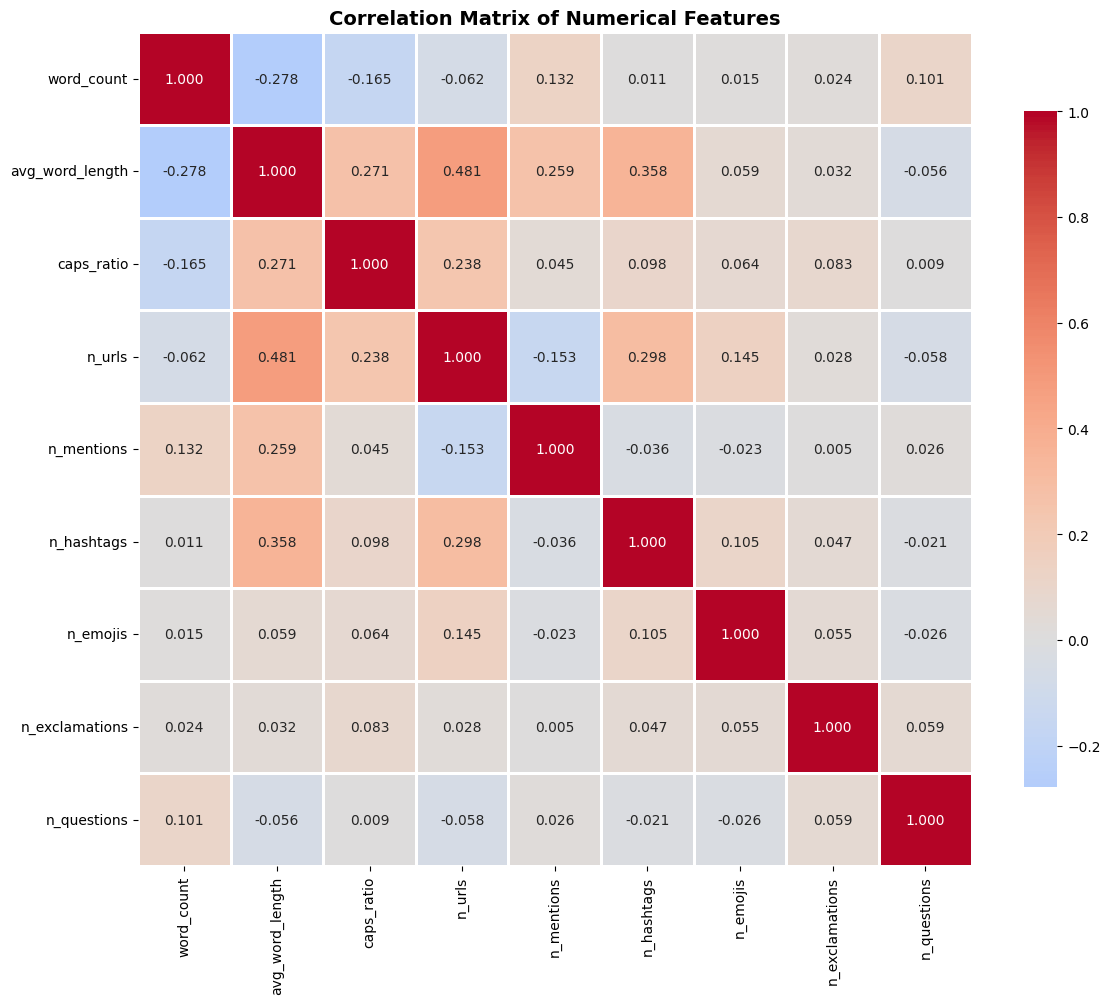


No high correlations found among selected features (all |r| < 0.7)
✓ Features are relatively independent


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check correlation between numerical features
correlation_matrix = train_data[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify high correlations (excluding diagonal)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("\nHigh correlation pairs (|r| > 0.7):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} <-> {feat2}: r={corr:.3f}")
else:
    print("\nNo high correlations found among selected features (all |r| < 0.7)")
    print("✓ Features are relatively independent")

## 9. Export Preprocessed Data

In [49]:
# Create output directory
output_dir = Path('..') / 'preprocessed_data'
output_dir.mkdir(exist_ok=True)

# Select columns to keep
columns_to_keep = [
    'id_EXIST',
    'tweet',              # Original text
    'text_light',         # Light cleaning
    'text_medium',        # Medium cleaning with pattern tokens
    'text_clean',         # Aggressive cleaning
    'task1', 'task2', 'task3',  # Labels (only in train)
    'task1_agreement'     # Agreement score
] + handcrafted_features

# For test data (no labels)
test_columns = ['id_EXIST', 'tweet', 'text_light', 'text_medium', 'text_clean', 'task1_agreement'] + handcrafted_features

# Export train/val/test as JSON
train_data[columns_to_keep].to_json(output_dir / 'train_preprocessed.json', orient='records', indent=2, force_ascii=False)
val_data[columns_to_keep].to_json(output_dir / 'val_preprocessed.json', orient='records', indent=2, force_ascii=False)
test_df[test_columns].to_json(output_dir / 'test_preprocessed.json', orient='records', indent=2, force_ascii=False)

print("Preprocessed data exported to:")
print(f"  - {output_dir / 'train_preprocessed.json'} ({len(train_data)} samples)")
print(f"  - {output_dir / 'val_preprocessed.json'} ({len(val_data)} samples)")
print(f"  - {output_dir / 'test_preprocessed.json'} ({len(test_df)} samples)")

print(f"\nColumns in exported files: {len(columns_to_keep)}")
print(f"  - Text versions: 4 (original + 3 cleaned)")
print(f"  - Labels: 3 (task1, task2, task3)")
print(f"  - Handcrafted features: {len(handcrafted_features)}")
print(f"  - Metadata: 2 (id_EXIST, task1_agreement)")

Preprocessed data exported to:
  - ..\preprocessed_data\train_preprocessed.json (5154 samples)
  - ..\preprocessed_data\val_preprocessed.json (910 samples)
  - ..\preprocessed_data\test_preprocessed.json (934 samples)

Columns in exported files: 22
  - Text versions: 4 (original + 3 cleaned)
  - Labels: 3 (task1, task2, task3)
  - Handcrafted features: 13
  - Metadata: 2 (id_EXIST, task1_agreement)


## 10. Summary and Next Steps

### Preprocessing Completed

1. **Text Cleaning**:
   - Created 3 versions: `text_light`, `text_medium`, `text_clean`
   - Preserved original tweets for reference

2. **Feature Engineering**:
   - Extracted 13 handcrafted features based on EDA insights
   - Removed redundant `tweet_length` (r=0.929 with word_count)
   - Prioritized `avg_word_length` (most informative)
   - Included chi-square significant features (has_url, has_hashtag)

3. **Data Splitting**:
   - Training: 85% (stratified by task1)
   - Validation: 15% (stratified by task1)
   - Test: separate file (no labels)

4. **Sample Weighting**:
   - Calculated `task1_agreement` for all samples
   - Can be used to weight training samples

### Next Steps

**Notebook 03**: Baseline Models
- Logistic Regression with TF-IDF
- SVM with different kernels
- Naive Bayes
- Random Forest with handcrafted features
- Evaluation: Accuracy, F1-score, Precision, Recall

**Notebook 04**: Deep Learning Models
- LSTM/GRU with word embeddings
- CNN for text classification
- Bidirectional architectures

**Notebook 05**: Transformer Models
- BETO (Spanish BERT)
- RoBERTa-es
- mBERT (multilingual)
- Fine-tuning strategies